# Lens Calculator for Fabry-Perot Cavity

Calulate the change in a beam of light starting at the beam waist in a Fabry-Perot cavity then going through a series of lenses

In [1]:
import numpy as np
import sympy as sym
import matplotlib as mp
import matplotlib.pyplot as plt
from sympy.physics.mechanics import init_vprinting

init_vprinting()

## Important Functions

In [2]:
# Functions for lenses and distance
# =================================
def as_sym(x, use_sym=False):
    if use_sym == False:
        M = np.array(x)
    elif use_sym == True:
        M = sym.Matrix(x)
    else:
        M = print('Error: Please specify True or False for Sympy')
    return M

# Curved interface matrix
def interface(ni, nf, R, use_sym=False):
    A = [[1, 0], [(ni - nf)/(R*nf), ni/nf]]
    M = as_sym(A, use_sym)
    return M

# Distance matrix
def dist(d, use_sym=False):
    A = [[1, d], [0, 1]]
    M = as_sym(A, use_sym)
    return M

# Lens matrix
# Use sym.oo for flat interface
def lens(n_medium=1, n_lens=1, R_in=sym.oo, R_out=sym.oo, thickness=5, use_sym=False):
    interface_in = interface(n_medium, n_lens, R_in, use_sym)
    interface_out = interface(n_lens, n_medium, R_out, use_sym)
    lens_thickness = as_sym([[1, thickness], [0, 1]], use_sym)
    return interface_out@lens_thickness@interface_in

# Functions for the beam:
# =======================

# Waist (radius) of beam and 
# angle with respect to x-axis
def beam(waist, angle, use_sym=False):
    return as_sym([[waist], [angle]], use_sym)

# Rayleigh length
def z_Rayleigh(beam_front_curvature, dist, use_sym=False):
    if use_sym == False:
        z_R = np.sqrt(dist * (beam_front_curvature-dist))
    elif use_sym == True:
        z_R = sym.sqrt(dist * (beam_front_curvature-dist))
    else: 
        z_R = print('Error: Please specify True or False for Sympy')
    return z_R

# Beam waist size
def waist0(wavelength, z_R, use_sym=False):
    if use_sym == False:
        w_0 = np.sqrt((wavelength/sym.pi) * z_R)
    elif use_sym == True:
        w_0 = sym.sqrt((wavelength/np.pi) * z_R)
    else: 
        w_0 = print('Error: Please specify True or False for Sympy')
    return w_0

# Beam waist after certain distance z
def waistz(wavelength, z_R, z, use_sym=False):
    w_0 = waist0(wavelength, z_R, use_sym)
    if use_sym == False:
        w_z =  w_0 * np.sqrt(1 + (z/z_R)**2)
    elif use_sym == True:
        w_z =  w_0 * sym.sqrt(1 + (z/z_R)**2)
    else: 
        w_z = print('Error: Please specify True or False for Sympy') 
    return w_z

# Complex beam parameter
def q_CBP(dist, z_R):
    return dist + z_R*1j

# The angle the beam makes with the 
# mirror of the Fabry-Perot cavity
def Theta0(wavelength, mirror_curvature, mirror_focal, lens_pos, use_sym=False):
    # We want the radius of curvature of the beam front to match
    # the radius of curvature of the mirror when it hits the 
    # mirror after originating from the focal length of the mirror
    z_r = z_Rayleigh(mirror_curvature, mirror_focal, use_sym)
    w_z = waistz(wavelength, z_r, mirror_focal, use_sym)
    theta = w_z/lens_pos
    return theta

## Symbols

In [3]:
# Beam waists
w0, wf = sym.symbols('w_0 w_f', real=True)

# Beam angle (small angles)
theta0, thetaf = sym.symbols('theta_0 theta_f', real=True)

# Complex beam parameters
q0, qf = sym.symbols('q_0 q_f')

# Distances
# For lens thickness
d0, d1, d2, d3, d4 = sym.symbols('d:5', real=True)
# For distance between lens
x0, x1, x2, x3, x4 = sym.symbols('x:5')

# Indicies of refraction
nl, nm = sym.symbols('n_l n_m', real=True)

# Radius of curvature for lens
r00, r01, r10, r11, r20, r21 = sym.symbols('r_{00} r_{01} r_{10} r_{11} r_{20} r_{21}')

## Matricies for beam, lenses, and distances

In [4]:
beam0 = beam(w0, theta0, use_sym=True)
beamf = beam(wf, thetaf, use_sym=True)

dist0 = dist(x0, use_sym=True)
lens0 = lens(nm, nl, r00, sym.oo, d0, use_sym=True)
dist1 = dist(x1, use_sym=True)
lens1 = lens(nm, nl, r10, sym.oo, d1, use_sym=True)
dist2 = dist(x2, use_sym=True)
lens2 = lens(nm, nl, r20, sym.oo, d2, use_sym=True)

## Commence calculation using matricies

In [5]:
Final = (lens2@dist2@lens1@dist1@lens0@dist0@beam0).applyfunc(sym.simplify)

# display(Final)

In [6]:
# Sub in the stuff we know
# Lengths in units of mm
Final_sub1 = Final.subs({nm:1, nl:1.515, r00:-50, 
                         x0:25, d0:7.2, d1:5, d2:5, 
                         w0:0,
                         theta0:Theta0(780e-6, 2*25, 25, 25, use_sym=True)
                        }).applyfunc(sym.simplify)
# display(Final_sub1)

In [7]:
# Sub in the radius of curvatures
# for the lens we want to use 
Final_sub2 = Final_sub1.subs({r10:100, r20:200}).applyfunc(sym.simplify)
# display(Final_sub2)

In [8]:
sym.solvers.solve(Final_sub2 - beamf.subs({wf:1.12, thetaf:0}), (x1, x2))

## Calculation using complex beam parameter

In [9]:
beamq0 = beam(q0, 1, use_sym=True)
beamqf = beam(qf, 1, use_sym=True)

In [10]:
Finalq = (lens2@dist2@lens1@dist1@lens0@dist0@beamq0).applyfunc(sym.simplify)

Finalq_sub1 = Finalq.subs({nm:1, nl:1.515, r00:-50, 
                         x0:25, d0:7.2, d1:5, d2:5
                         }).applyfunc(sym.simplify)

Finalq_sub2 = Finalq_sub1.subs({r10:100, r20:200}).applyfunc(sym.simplify)

In [11]:
k = sym.pi / 780e-6
Q0 = 1j * k * 0.08**2
Qf = 1j * k * 0.5**2

Finalq_sub3 = Finalq_sub2.subs({q0:Q0})
Beamqf_sub = beamqf.subs({qf:Qf})

solution = sym.solvers.solve(Finalq_sub3[0]/Finalq_sub3[1] - Beamqf_sub[0], (x1, x2))

In [12]:
Q0.simplify()

In [13]:
X2 = sym.solvers.solve(solution[0][0], x2)
X1 = solution[0][0].subs({x2: X2[0]}).simplify()
display(X1, X2)

## Forward propagation

In [125]:
# lens(1, 1.515, np.inf, -50, 7.5) @ dist(30) @ lens(1, 1.515, np.inf, 100, 5) @ dist(70) @ lens(1, 1.515, np.inf, 200, 5)
@np.vectorize
def beam_prop_cavity(x, wavelength=780e-7, w0=0.5):
    q1 = 1/(1/10e9 - 1j * wavelength / (np.pi * w0))
    A = dist(x) @ lens(1, 1.515, np.inf, -50, 7.5) @ dist(50) @ lens(1, 1.515, np.inf, 200, 5) @ dist(150) @ lens(1, 1.515, np.inf, 100, 5) @ beam(q1, 1)
    qf = A[0]/A[1]
    return np.sqrt(-wavelength / (np.pi * np.imag(1/qf)))

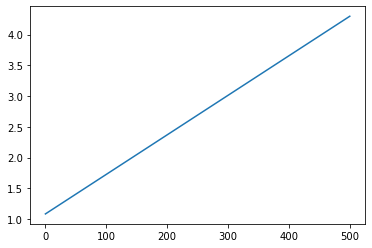

In [126]:
x = np.linspace(0, 500, 400)
plt.plot(x, beam_prop_cavity(x))

In [95]:
test(x)

array([0.00672625, 0.00564037, 0.00468939, 0.00397144, 0.0036276 ,
       0.0037619 , 0.00433009, 0.0051916 , 0.00622583, 0.00736034,
       0.00855532, 0.00978865, 0.01104749, 0.01232403, 0.01361329,
       0.01491198, 0.01621782, 0.01752922, 0.01884501, 0.02016435,
       0.02148657, 0.02281117, 0.02413777, 0.02546605, 0.02679575,
       0.02812669, 0.02945868, 0.0307916 , 0.03212533, 0.03345976,
       0.03479483, 0.03613046, 0.03746659, 0.03880317, 0.04014015,
       0.04147749, 0.04281517, 0.04415314, 0.04549139, 0.04682989,
       0.04816862, 0.04950756, 0.0508467 , 0.05218601, 0.05352549,
       0.05486513, 0.05620491, 0.05754482, 0.05888485, 0.060225  ,
       0.06156525, 0.06290561, 0.06424606, 0.06558661, 0.06692723,
       0.06826793, 0.06960871, 0.07094956, 0.07229047, 0.07363145,
       0.07497248, 0.07631357, 0.07765472, 0.07899591, 0.08033715,
       0.08167844, 0.08301977, 0.08436114, 0.08570255, 0.087044  ,
       0.08838549, 0.089727  , 0.09106855, 0.09241014, 0.09375